<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

# Text Summarization

Суммаризация текста на примере генерации "сжатых" новостей. Рассмотрим некоторые базовые решения и познакомимся с архитектурами нейросетей для решения задачи.
Датасет: gazeta.ru

Загрузим датасет и необходимые библиотеки

In [1]:
from IPython.display import clear_output
!pip -q install razdel networkx pymorphy2 nltk rouge==0.3.1 summa
!pip install youtokentome
clear_output()

In [2]:
import json
import random
import youtokentome as yttm
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
import razdel
from tqdm.notebook import tqdm
import copy
import math
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

from sklearn.preprocessing import minmax_scale

import matplotlib
import time
import re
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt

In [3]:
# фиксация SEED
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt
clear_output()

In [5]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Определяем на чем у нас будут производиться вычисления (cuda/cpu)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  
device

CUDA is available!  Training on GPU ...


device(type='cuda', index=0)

In [6]:
!nvidia-smi

Sun Jun 12 09:58:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dataset

Посмотрим на то, как устроен датасет

In [7]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [8]:
def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle(records)
    return records

In [9]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [10]:
def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

## Extractive RNN

### BPE
Для начала сделаем BPE токенизацию

In [11]:
def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

train_bpe(train_records, "BPE_model.bin")

### Словарь
Составим словарь для индексации токенов

In [12]:
bpe_processor = yttm.BPE('BPE_model.bin')
vocabulary = bpe_processor.vocab()

### Кэш oracle summary
Закэшируем oracle summary, чтобы не пересчитывать их каждый раз

In [13]:
def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Составление батчей

In [14]:
class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True, lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)
                
                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences)[1]
                else:   
                    sentences_indicies = record["oracle_sentences"]
                
                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                
                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device)
            # we add index 2 for padding
            # YOUR CODE
            tensor_outputs = torch.ones((self.batch_size, max_sentences), dtype=torch.float32, device=self.device) * 2

            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            tensor_outputs = tensor_outputs.long()
            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [15]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 32, bpe_processor, device=device)
val_iterator = BatchIterator(ext_val_records, vocabulary, 32, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)

## Extractor -  SummaRuNNer
 https://arxiv.org/pdf/1611.04230.pdf


### Homework

* В данной реализации в `outputs` в качестве padding используется индекс 0. Измените в функции \_\_iter__ индекс padding, чтобы он не совпадал с классом 0 или 1, например, 2.
* В качестве criterion используйте `CrossEntropyLoss`вместо `BCEWithLogitsLoss`
* Из-за смены criterion, вы уже должны подавать на вход criterion ни одно число, а logits для каждого класса. Перед подачей logits вы можете отфильтровать предсказания для класса padding. В этом пункте вам придется изменять файл `train_model.py`, а именно функциии `train` и `evaluate`.
* Используйте два варианта обучения: c весами в `CrossEntropyLoss` и без
* Также сравните `inference`, когда вы ранжируете logits, и когды вы выбирате предложения, у которых logits > 0, в двух вариантах обучения. 
* Реализуйте дополнительно характеристику предложения `novelty`. Как влияет добавление `novelty` на качество summary?
* Постарайтесь улучшить качество модели, полученной на семинаре: $BLEU \approx 0.45$

In [16]:
PAD_IDX = 2

In [17]:
class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.dropout_layer(self.embedding_layer(inputs))
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size, hidden_size]
        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_content=True,
                 use_salience=True,
                 use_novelty=True,
                 token_embedding_dim = 128,
                 sentence_encoder_hidden_size = 256,
                 hidden_size = 256,
                 bidirectional=True,
                 sentence_encoder_n_layers = 2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers = 2,
                 dropout = 0.3):
        
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.novelty_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.tanh_layer = nn.Tanh()

        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty

    def forward(self, inputs, hidden=None):
        # parameters of the probability
        content = 0
        salience = 0
        novelty = 0

        # [batch_size, seq num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        # [batch_size *  seq num, seq_len, hidden_size] -> [batch_size, seq num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        # [batch_size, seq num, hidden_size]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # [batch_size, hidden_size]

        # W * h^T
        if self.use_content:
            content = self.content_linear_layer(outputs).squeeze(2) # 1-representation
        # [batch_size, seq num]

        # h^T * W * d
        if self.use_salience:
            salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2) # 2-representation
        # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]

        if self.use_novelty:
            # at every step add novelty to prediction of the sentence
            predictions = content + salience
            
            # 0) initialize summary_representation and novelty by zeros
            # https://github.com/kedz/nnsum/blob/master/nnsum/module/sentence_extractor/summarunner_sentence_extractor.py
            novelty = torch.zeros((batch_size, sentences_count)).to(device)
            summary_representation = torch.zeros((batch_size, self.hidden_size*2)).to(device)

            for sentence_num in range(sentences_count):

                # 1) take sentence_num_state from outputs(representation of the sentence with number sentence_num)
                sentence_num_state = outputs[:, sentence_num, :]
                # [seq num, hidden_size]

                # 2) calculate novelty for current sentence
                novelty[:, sentence_num] = -torch.bmm(sentence_num_state.unsqueeze(1), 
                                                      self.novelty_linear_layer(torch.tanh(summary_representation)).unsqueeze(2)).squeeze(2).squeeze(1)
                # [seq num]
                
                # 3) add novelty to predictions
                predictions[:, sentence_num] += novelty[:, sentence_num]

                # 4) calculcate probability for current sentence
                probabilities = torch.sigmoid(predictions[:, sentence_num])

                # 5) add sentence_num_state with the weight which is equal to probability to summary_representation
                summary_representation += torch.mv(sentence_num_state.transpose(0, 1), probabilities)

            return predictions


        return content + salience

## Model
$P\left(y_{j} = 1 \mid \mathbf{h}_{j}, \mathbf{s}_{j}, \mathbf{d}\right)=\sigma\left(W_{c} \mathbf{h}_{j} + \mathbf{h}_{j}^{T} W_{s} \mathbf{d}\right)$
--------------------

In [18]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 2927617


In [19]:
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")

sentence_encoder.embedding_layer.weight: 1280000
sentence_encoder.rnn_layer.weight_ih_l0: 65536
sentence_encoder.rnn_layer.weight_hh_l0: 65536
sentence_encoder.rnn_layer.bias_ih_l0: 512
sentence_encoder.rnn_layer.bias_hh_l0: 512
sentence_encoder.rnn_layer.weight_ih_l0_reverse: 65536
sentence_encoder.rnn_layer.weight_hh_l0_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l0_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l0_reverse: 512
sentence_encoder.rnn_layer.weight_ih_l1: 131072
sentence_encoder.rnn_layer.weight_hh_l1: 65536
sentence_encoder.rnn_layer.bias_ih_l1: 512
sentence_encoder.rnn_layer.bias_hh_l1: 512
sentence_encoder.rnn_layer.weight_ih_l1_reverse: 131072
sentence_encoder.rnn_layer.weight_hh_l1_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l1_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l1_reverse: 512
rnn_layer.weight_ih_l0: 131072
rnn_layer.weight_hh_l0: 65536
rnn_layer.bias_ih_l0: 512
rnn_layer.bias_hh_l0: 512
rnn_layer.weight_ih_l0_reverse: 131072
rnn_layer.wei

In [20]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        # YOUR CODE
        model.train()
        logits = model(batch["inputs"])
        target = batch["outputs"]
        prob = torch.sigmoid(logits)
        input = torch.cat([(1-prob).unsqueeze(-1), prob.unsqueeze(-1)], dim=2)
        input = input.view(-1,2)
        target = target.view(-1,1)[:,0]
        loss = criterion(input, target)

        #choice_2
        #output_1d = model(batch["inputs"].to(device)).view(-1)
        #batch_outputs_1d = batch["outputs"].view(-1).to(device)
        #output_1d = output_1d.unsqueeze(-1)
        #output = torch.cat((-output_1d, output_1d),-1).to(device)
        #loss = criterion(output, batch_outputs_1d)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        history.append(loss.item())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            ax[0].grid()
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            ax[1].grid()
            plt.legend()
            
            plt.show()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    history = []
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            # YOUR CODE
            model.eval()
            logits = model(batch["inputs"])
            target = batch["outputs"]
            prob = torch.sigmoid(logits)
            input = torch.cat([(1-prob).unsqueeze(-1), prob.unsqueeze(-1)], dim=2)
            input = input.view(-1,2)
            target = target.view(-1,1)[:,0]
            loss = criterion(input, target)

            #choice_2
            #output_1d = model(batch["inputs"].to(device)).view(-1)
            #batch_outputs_1d = batch["outputs"].view(-1).to(device)
            #output_1d = output_1d.unsqueeze(-1)
            #output = torch.cat((-output_1d, output_1d),-1).to(device)
            #loss = criterion(output, batch_outputs_1d)

            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train_with_logs(model, train_iterator, valid_iterator, optimizer, criterion, N_EPOCHS, CLIP):
    train_history = []
    valid_history = []
    best_valid_loss = float('inf')
    
    for epoch in range(N_EPOCHS):
        
        start_time = time.time()
        
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best-val-model.pt')
        
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
def punct_detokenize(text):
    text = text.strip()
    punctuation = ",.!?:;%"
    closing_punctuation = ")]}"
    opening_punctuation = "([}"
    for ch in punctuation + closing_punctuation:
        text = text.replace(" " + ch, ch)
    for ch in opening_punctuation:
        text = text.replace(ch + " ", ch)
    res = [r'"\s[^"]+\s"', r"'\s[^']+\s'"]
    for r in res:
        for f in re.findall(r, text, re.U):
            text = text.replace(f, f[0] + f[2:-2] + f[-1])
    text = text.replace("' s", "'s").replace(" 's", "'s")
    text = text.strip()
    return text

def postprocess(ref, hyp, is_multiple_ref=False, detokenize_after=False, tokenize_after=True):
    if is_multiple_ref:
        reference_sents = ref.split(" s_s ")
        decoded_sents = hyp.split("s_s")
        hyp = [w.replace("<", "&lt;").replace(">", "&gt;").strip() for w in decoded_sents]
        ref = [w.replace("<", "&lt;").replace(">", "&gt;").strip() for w in reference_sents]
        hyp = " ".join(hyp)
        ref = " ".join(ref)
    ref = ref.strip()
    hyp = hyp.strip()
    if detokenize_after:
        hyp = punct_detokenize(hyp)
        ref = punct_detokenize(ref)
    if tokenize_after:
        hyp = hyp.replace("@@UNKNOWN@@", "<unk>")
        hyp = " ".join([token.text for token in razdel.tokenize(hyp)])
        ref = " ".join([token.text for token in razdel.tokenize(ref)])
    return ref, hyp

In [21]:
from sklearn.utils.class_weight import compute_class_weight
target = np.fromiter((v for batch in train_iterator for v in batch["outputs"].detach().cpu().numpy().flatten()), dtype=int)
target = target[target != PAD_IDX]
class_weight = torch.tensor(compute_class_weight(class_weight='balanced',
                                    classes=np.unique(target),
                                    y=target), dtype=torch.float).to(device)

## Inference

In [22]:
def inference_summarunner(model, iterator, top_k=3):
    references = []
    predictions = []

    model.eval()
    for batch in iterator:
        logits = model(batch['inputs'])
        sum_in = torch.argsort(logits, dim=1)[:, -top_k:]
        
        for i in range(len(batch['outputs'])):
            summary = batch['records'][i]['summary'].lower()

            try:
              pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i]])
            except (IndexError):
              continue
              
            summary, pred_summary = postprocess(summary, pred_summary)
            references.append(summary)
            predictions.append(pred_summary)
    calc_scores(references, predictions)

In [23]:
def inference_summarunner_th(model, iterator, th):
    references = []
    predictions = []

    model.eval()
    for batch in iterator:
        logits = model(batch['inputs'])
        logits = minmax_scale(logits.detach().cpu(), feature_range=(-1,1), axis=1, copy=True)
        logits = torch.FloatTensor(logits)

        for i in range(len(batch['outputs'])):

            sum_in = torch.nonzero(logits[i]>th, as_tuple=True)[0]
            summary = batch['records'][i]['summary'].lower()

            try:
              pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in])
            except (IndexError):
              continue
              
            summary, pred_summary = postprocess(summary, pred_summary)
            references.append(summary)
            predictions.append(pred_summary)
    calc_scores(references, predictions)

In [24]:
def train_final(use_class_weights, N_EPOCHS, CLIP, lr=1e-5):
    optimizer = optim.Adam(model.parameters(), lr)
    if use_class_weights:
        # weights depend on the number of objects of class 0 and 1
        # YOUR CODE
        criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX, weight=class_weight)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

### Эксперимент со случайными весами

In [ ]:
# Эксперимент со случайными весами
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)
inference_summarunner(model, test_iterator, 3)

Count: 218
Ref: морские порты россии – это не только одно из ключевых звеньев транспортной системы , но и залог для увеличения грузооборота и экспорта , а соответственно , и вклада в рост российской экономики . именно поэтому портовая деятельность вошла в числе национальных приоритетов . интересно , что морские порты в россии будут развиваться в основном на частные деньги . важно не только строительство самих портов , но и развитие все транспортной инфраструктуры , включая автодорожные и железнодорожные подходы к портам .
Hyp: морские порты россии получат новое развитие в рамках нацпроекта « комплексный план модернизации и расширения магистральной инфраструктуры » . предполагается , порты дальневосточного , северо-западного , волго-каспийского и азово-черноморского бассейнов и другие к 2024 году увеличат мощность до 1,3 млрд тонн ( прирост — не менее 336 млн т ) . развитие портовой инфраструктуры и автодорожных подходов к портам , строительство 9 ледоколов и одного аварийно-спасательно

## Обучим модель (use_novelty = False, use_class_weights = False)

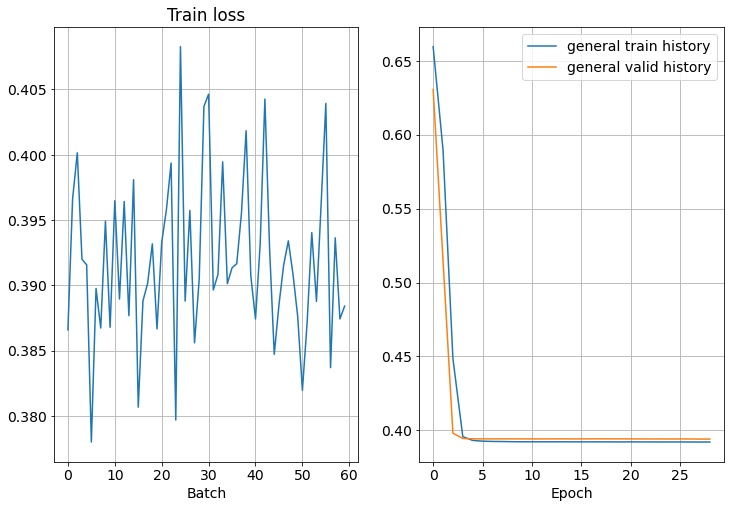

Epoch: 30 | Time: 0m 8s
	Train Loss: 0.392 | Train PPL:   1.480
	 Val. Loss: 0.394 |  Val. PPL:   1.483
Count: 256
Ref: для борьбы с с недобросовестными азс , недоливающими топливо , будут использоваться специальные приборы , а также проверки программного обеспечения . в этом вопросе росстандарт намерен использовать опыт , полученный в сфере регулирования работы игровых автоматов .
Hyp: росстандарт готовит арсенал для проверок автозаправочных станций на недолив топлива : проверяться будет не конкретная колонка , а ее работа как системы , в том числе ее связь с оператором за кассой . контролеров при работе методом тайного покупателя вооружат скрытым прибором , который сможет « ловить » недолив на уровне 1 % . кроме того , новый гост защитит топливораздаточные колонки от приспособлений и вредоносного по , обманывающих расходомер .
BLEU:  0.44225303105459424
ROUGE:  {'rouge-1': {'f': 0.31182369116706404, 'p': 0.2891008385456055, 'r': 0.3551590796406379}, 'rouge-2': {'f': 0.136443164031052

In [25]:
N_EPOCHS = 30
CLIP = 1

model = SentenceTaggerRNN(vocab_size, use_novelty = False).to(device)
train_final(False, N_EPOCHS, CLIP)
model.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

In [33]:
# Инференс с отсечкой по threshold
inference_summarunner_th(model, test_iterator, .5)

Count: 256
Ref: экс-депутат рады александр ковтуненко устроил скандал в эфире телеканала « россия 1 » . он поддержал идею другого бывшего нардепа рефата чубарова « отметить 450 лет со дня сожжения москвы » крымским ханом девлет-гиреем . кроме того , ковтуненко назвал россию « бывшей украинской колонией » .
Hyp: скандал в эфире программы « 60 минут » устроил бывший депутат верховной рады александр ковтуненко .
BLEU:  0.45896064721741514
ROUGE:  {'rouge-1': {'f': 0.30677258590915035, 'p': 0.3475847744841105, 'r': 0.30719857890650965}, 'rouge-2': {'f': 0.1391687270211789, 'p': 0.16045343040220947, 'r': 0.142284676020296}, 'rouge-l': {'f': 0.25079537484995995, 'p': 0.3078593333329834, 'r': 0.2722590707874975}}


## Обучим модель (use_novelty = False, use_class_weights = True)

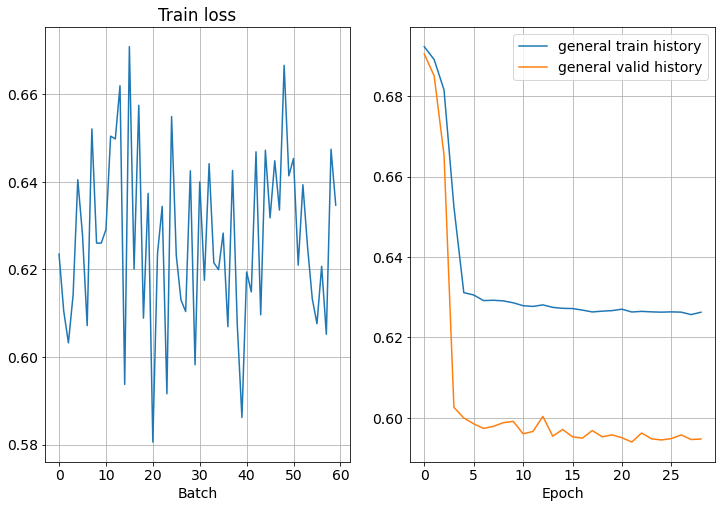

Epoch: 30 | Time: 0m 9s
	Train Loss: 0.626 | Train PPL:   1.870
	 Val. Loss: 0.595 |  Val. PPL:   1.813
Count: 256
Ref: американские и иракские разведслужбы , а также пентагон считают , что украинский boeing 737 , потерпевший крушение в тегеране , при котором погибло 168 человек , был поражен ударом российской зенитной ракетной системы « тор м 1 » пво ирана . по мнению источника из пентагона , инцидент был случайным — противовоздушная оборона ирана , вероятно , активно работала по всем воздушным целям после ракетного обстрела со стороны сша .
Hyp: самолет boeing 737-800 « международных авиалиний украины » , потерпевший крушение в тегеране , при котором погибло 168 человек , был поражен ударом зенитной ракетной системы – об этом newsweek рассказали представитель пентагона , высокопоставленный сотрудник американской разведки и сотрудник иракской разведки . по их словам , самолет был поражен ракетным выстрелом зрк « тор м 1 » пво ирана , известной в нато как gauntlet . по мнению пентагона

In [34]:
if os.path.isfile('/content/best-val-model.pt'):
  os.remove('/content/best-val-model.pt') 

model = SentenceTaggerRNN(vocab_size, use_novelty = False).to(device)
train_final(True, N_EPOCHS, CLIP)
model.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

In [44]:
# Инференс с отсечкой по threshold
inference_summarunner_th(model, test_iterator, .5)

Count: 256
Ref: россияне могут продлить себе новогодние каникулы , присоединив к ним свой отпуск , рассказали в роструде . работник может уйти в отпуск в любое время , в том числе – и с 9 января , если это было заранее оговорено с работодателем или прописано в графике отпусков . при этом за две недели до начала отпуска работник должен быть уведомлен о нем . ранее сми сообщали , что россиянам сократят новогодние каникулы , перенеся два выходных на май .
Hyp: часть отпуска или весь отпуск полностью можно присоединить к новогодним каникулам или майским праздникам . однако для этого необходимо соблюсти ряд условий , сообщает « российская газета » со ссылкой на роструд .
BLEU:  0.47284726323052
ROUGE:  {'rouge-1': {'f': 0.30863746313393825, 'p': 0.33480940711001117, 'r': 0.31383286950162087}, 'rouge-2': {'f': 0.13981691268092417, 'p': 0.15178305485995597, 'r': 0.1464790104932912}, 'rouge-l': {'f': 0.2552304770642323, 'p': 0.29797353611064326, 'r': 0.2791777099292248}}


## Обучим модель (use_novelty = True, use_class_weights = False)

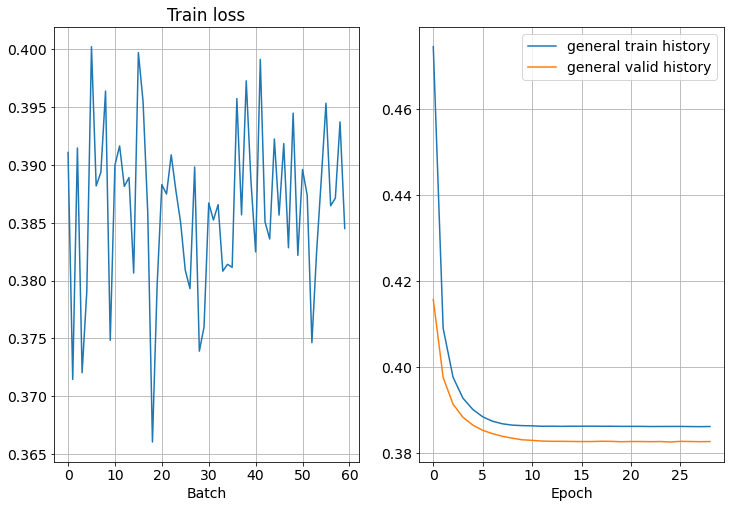

Epoch: 30 | Time: 0m 11s
	Train Loss: 0.386 | Train PPL:   1.471
	 Val. Loss: 0.383 |  Val. PPL:   1.466
Count: 247
Ref: опасные трещины найдены уже в десятках самолетов boeing 737 ng . американскому производителю , чьи новейшие лайнеры и так прикованы к земле из-за двух авиакатастроф , теперь грозят новые убытки .
Hyp: подозрения , павшие почти две недели назад на один из самых массовых самолетов в мире boeing 737 ng , подтвердились и теперь могут привести к отзыву треснувших самолетов , а для boeing — обернуться новыми репутационными и финансовыми потерями . как сообщают американские сми , число дефектных самолетов уже измеряется десятками . подобные трещины , вовремя не замеченные , привели к нескольким крушениям советских пассажирских ан-10 .
BLEU:  0.4037068609939744
ROUGE:  {'rouge-1': {'f': 0.2783340459711522, 'p': 0.25098902451333444, 'r': 0.3290264292286601}, 'rouge-2': {'f': 0.11285383231203777, 'p': 0.09976572840422328, 'r': 0.1388092642181583}, 'rouge-l': {'f': 0.2328061830

In [45]:
if os.path.isfile('/content/best-val-model.pt'):
  os.remove('/content/best-val-model.pt') 
model = SentenceTaggerRNN(vocab_size, use_novelty = True).to(device)
train_final(False, N_EPOCHS, CLIP)
model.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

In [58]:
# Инференс с отсечкой по threshold
inference_summarunner_th(model, test_iterator, 0.001)

Count: 256
Ref: в риме прошли переговоры глав мид и минобороны рф сергея лаврова и сергея шойгу с их итальянскими коллегами луиджи ди майо и лоренцо гуэрини в формате « 2 + 2 » . политики обсудили ситуацию в сирии , ливии , на украине , диалог россии с нато . отдельно министры обратили внимание на действия сша в сирии , а также необходимость для европы абстрагироваться от украинского кризиса в вопросах взаимодействия с москвой .
Hyp: в риме 18 февраля министры иностранных дел и обороны рф сергей лавров и сергей шойгу встретились с итальянскими коллегами луиджи ди майо и лоренцо гуэрини .
BLEU:  0.40778807169219483
ROUGE:  {'rouge-1': {'f': 0.27139913061865617, 'p': 0.35052298860057696, 'r': 0.2666771127709237}, 'rouge-2': {'f': 0.11908598087033825, 'p': 0.1612904733698099, 'r': 0.11850144327873613}, 'rouge-l': {'f': 0.20727090641014093, 'p': 0.307008066781927, 'r': 0.2334457411642894}}


## Обучим модель (use_novelty = True, use_class_weights = True)

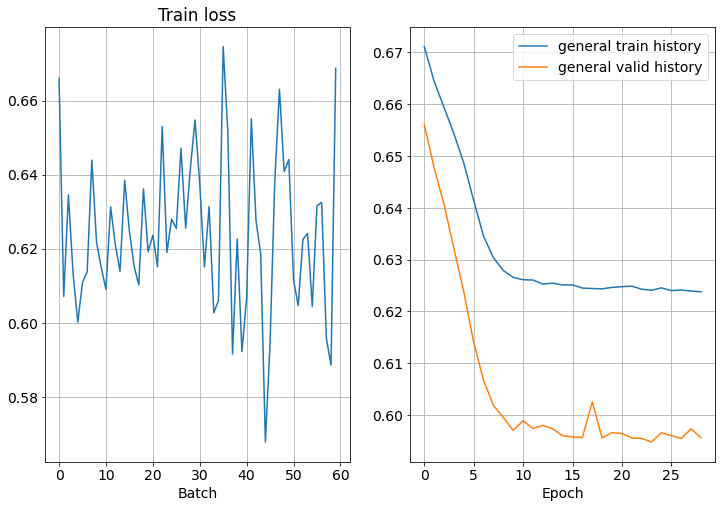

Epoch: 30 | Time: 0m 11s
	Train Loss: 0.624 | Train PPL:   1.866
	 Val. Loss: 0.595 |  Val. PPL:   1.813
Count: 256
Ref: экс-депутат рады александр ковтуненко устроил скандал в эфире телеканала « россия 1 » . он поддержал идею другого бывшего нардепа рефата чубарова « отметить 450 лет со дня сожжения москвы » крымским ханом девлет-гиреем . кроме того , ковтуненко назвал россию « бывшей украинской колонией » .
Hyp: скандал в эфире программы « 60 минут » устроил бывший депутат верховной рады александр ковтуненко . инцидент произошел на телеканале « россия 1 » . экс-нардеп поддержал идею другого бывшего украинского парламентария , лидера « меджлиса крымскотатарского народа » ( экстремистская организация , запрещена в рф ) рефата чубарова .
BLEU:  0.44674925060378357
ROUGE:  {'rouge-1': {'f': 0.31390996957558887, 'p': 0.2943140273165956, 'r': 0.35416244710992795}, 'rouge-2': {'f': 0.13833083065518084, 'p': 0.12774170969656698, 'r': 0.1613405353206704}, 'rouge-l': {'f': 0.26673876144913067,

In [70]:
if os.path.isfile('/content/best-val-model.pt'):
  os.remove('/content/best-val-model.pt') 
model = SentenceTaggerRNN(vocab_size, use_novelty = True).to(device)
train_final(True, N_EPOCHS, CLIP)
model.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

In [86]:
# Инференс с отсечкой по threshold
inference_summarunner_th(model, test_iterator, .001)

Count: 256
Ref: производство второго сезона сериала « лучшие в лос-анджелесе » с джессикой альбой в главной роли приостановлено из-за лесных пожаров к северу от лос-анджелеса . возгорание было вызвано опасными ветрами в сочетании с низкой влажностью и высокими температурами .
Hyp: из-за очередной вспышки лесных пожаров к северу от лос-анджелеса приостанавливается и переносится производство ряда сериалов , среди которых второй сезон спин-офф экшн-хита « плохие парни » — « лучшие в лос-анджелесе » с джессикой альбой в главной роли , пишет deadline . в долине санта-кларита вспыхнули три пожара , вызванные опасными ветрами в сочетании с низкой влажностью и высокими температурами .
BLEU:  0.4393667753880199
ROUGE:  {'rouge-1': {'f': 0.31177951342430177, 'p': 0.34949156385123625, 'r': 0.29857562360274903}, 'rouge-2': {'f': 0.1415989489127609, 'p': 0.15963186612637742, 'r': 0.1373051684867328}, 'rouge-l': {'f': 0.2605694350081897, 'p': 0.30923779412157276, 'r': 0.26384215865501615}}


## Вывод:

<table class="">
	<tbody>
		<tr>
			<td colspan="3" align="center"><b>BLEU</b <b> (inference without treshold)</td>
		</tr>
		<tr>
			<td></td>
			<td align="center"><b>Class_weight</b <b> (True)</b</td>
			<td align="center"><b>Class_weight</b <b> (False)</td>
		</tr>
		<tr>
			<td><b>Novelty</b <b> (True)</td>
			<td align="center">0.45</td>
			<td align="center">0.4</td>
		</tr>
		<tr>
			<td><b>Novelty</b <b> (False)</b</td>
			<td align="center">0.45</td>
			<td align="center">0.45</td>
		</tr>
	</tbody>
</table>

---

<table class="">
	<tbody>
		<tr>
			<td colspan="3" align="center"><b>BLEU</b <b> (inference with treshold)</td>
		</tr>
		<tr>
			<td></td>
			<td align="center"><b>Class_weight</b <b> (True)</b</td>
			<td align="center"><b>Class_weight</b <b> (False)</td>
		</tr>
		<tr>
			<td><b>Novelty</b <b> (True)</td>
			<td align="center">0.44</td>
			<td align="center">0.41</td>
		</tr>
		<tr>
			<td><b>Novelty</b <b> (False)</b</td>
			<td align="center">0.47</td>
			<td align="center">0.46</td>
		</tr>
	</tbody>
</table>

Максимальное значение BLEU ≈ 0.47 получено с использованием class_weight при выборе предложений, у которых logit > 0.5. Использование novelty не оказывает видимого влияния на увеличение BLEU. При этом, эксперименты со случайными весами иногда показывали еще бОльшее значение ≈ 0.49, что, конечно, не подлежит серьезному рассмотрению. При этом использование эмпирически подобранных значений treshold во всех случаях позволяет добиться более высоких значений BLEU.